In [1]:
'''
key:(c, c-sharp, d, e-flat, e, f, f-sharp, g, a-flat, a, b-flat, b) 0 - 11

mode: (minor, major) 0, 1

The time signature: 
ranges from 3 to 7 indicating time signatures of 3/4, to 7/4. 
A value of -1 may indicate no time signature, 
while a value of 1 indicates a rather complex or changing time signature

release : album name where the song comes from

Confidence Values
Many elements at the track and lower levels of analysis include confidence values,
a floating-point number ranging from 0.0 to 1.0. Confidence indicates the 
reliability of its corresponding attribute. Elements carrying a small 
confidence valueshould be considered speculative. There may not be sufficient 
data in the audio to compute the element with highcertainty
'''

'''
categorical features:
mode
time signature
key
'''

'\ncategorical features:\nmode\ntime signature\nkey\n'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d    
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import norm
%matplotlib inline

In [3]:
songs = pd.read_csv('song_hotness.csv')
songs['year'] = songs['year'].replace({0:np.nan})
songs = songs[~(songs['song_hotttnesss'].isnull())]
songs = songs[songs['song_hotttnesss'] > 0]
# songs['time_signature'] = songs['time_signature'].where((songs['time_signature'] >=3))
# songs['time_signature x year'] = songs['time_signature'] * songs['year']

In [4]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4215 entries, 0 to 10000
Data columns (total 22 columns):
artist_familiarity           4215 non-null float64
artist_hotttnesss            4215 non-null float64
artist_id                    4215 non-null object
artist_latitude              1656 non-null float64
artist_location              2705 non-null object
artist_longitude             1656 non-null float64
artist_name                  4215 non-null object
duration                     4215 non-null float64
end_of_fade_in               4215 non-null float64
key                          4215 non-null int64
key_confidence               4215 non-null float64
loudness                     4215 non-null float64
mode                         4215 non-null int64
mode_confidence              4215 non-null float64
release                      4215 non-null object
song_hotttnesss              4215 non-null float64
start_of_fade_out            4215 non-null float64
tempo                        4215

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022E5C8F1358>,
      dtype=object)

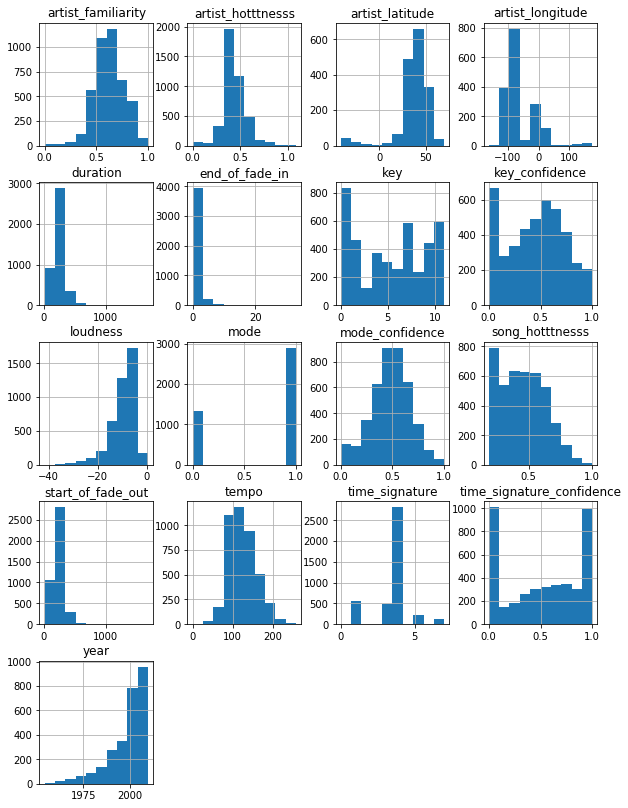

In [5]:
songs.hist(figsize=(10,14))

In [6]:
songs.shape

(4215, 22)

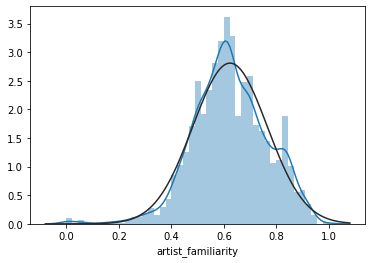

In [7]:
sns.distplot(songs['artist_familiarity'], fit= norm)

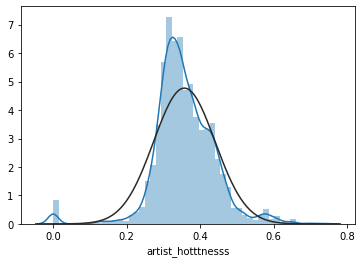

In [8]:
sns.distplot(np.log(songs['artist_hotttnesss']+1), fit= norm)

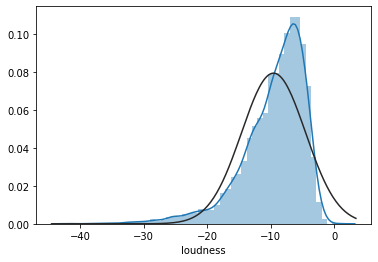

In [9]:
sns.distplot(songs['loudness'], fit= norm)

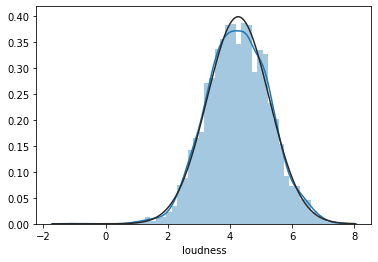

In [10]:
sns.distplot(np.log(songs['loudness']**2), fit= norm)

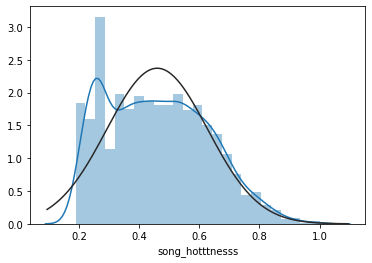

In [11]:
sns.distplot(songs['song_hotttnesss'], fit= norm)

In [12]:
songs.corr()['song_hotttnesss'].sort_values()

artist_longitude            -0.038854
mode                        -0.031250
key_confidence              -0.014555
end_of_fade_in              -0.013917
mode_confidence             -0.005820
start_of_fade_out            0.000729
duration                     0.001457
key                          0.007911
time_signature_confidence    0.018778
time_signature               0.039309
year                         0.063803
tempo                        0.071165
artist_latitude              0.084294
loudness                     0.211029
artist_hotttnesss            0.484297
artist_familiarity           0.506589
song_hotttnesss              1.000000
Name: song_hotttnesss, dtype: float64

In [13]:
# len(songs[songs['song_hotttnesss'] == 0])

In [14]:
mode_labels = []
unique_mode = len(songs['mode'].unique())
for num in range(unique_mode):
    string = f'mode_{num}'
    mode_labels.append(string)
mode_labels

['mode_0', 'mode_1']

In [15]:
time_sign_labels = []
unique_time_signature = len(songs['time_signature'].unique())
for num in range(unique_time_signature):
    string = f'time_sign_{num}'
    time_sign_labels.append(string)
time_sign_labels

['time_sign_0',
 'time_sign_1',
 'time_sign_2',
 'time_sign_3',
 'time_sign_4',
 'time_sign_5']

In [16]:
key_labels = []
unique_key = len(songs['key'].unique())
for num in range(unique_key):
    string = f'key_{num}'
    key_labels.append(string)
key_labels

['key_0',
 'key_1',
 'key_2',
 'key_3',
 'key_4',
 'key_5',
 'key_6',
 'key_7',
 'key_8',
 'key_9',
 'key_10',
 'key_11']

In [17]:
all_labels_cat = []
for label in mode_labels:
    all_labels_cat.append(label)
for label in time_sign_labels:
    all_labels_cat.append(label)
for label in key_labels:
    all_labels_cat.append(label)
all_labels_cat

['mode_0',
 'mode_1',
 'time_sign_0',
 'time_sign_1',
 'time_sign_2',
 'time_sign_3',
 'time_sign_4',
 'time_sign_5',
 'key_0',
 'key_1',
 'key_2',
 'key_3',
 'key_4',
 'key_5',
 'key_6',
 'key_7',
 'key_8',
 'key_9',
 'key_10',
 'key_11']

In [18]:
categorical = ['mode', 'time_signature', 'key']
numerical = ['loudness', 'tempo', 'duration', 'start_of_fade_out', 'end_of_fade_in', 'key_confidence', 
             'time_signature_confidence', 'mode_confidence', 'artist_familiarity', 'artist_hotttnesss']

In [19]:
all_labels = []
for label in all_labels_cat:
    all_labels.append(label)
for label in numerical:
    all_labels.append(label)

In [20]:
class getcategories(BaseEstimator, TransformerMixin):
    def __init__(self, category):
        self.category = category
    def fit(self, X):
        return self
    def transform(self, X):
        return X[self.category]

In [21]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4215 entries, 0 to 10000
Data columns (total 22 columns):
artist_familiarity           4215 non-null float64
artist_hotttnesss            4215 non-null float64
artist_id                    4215 non-null object
artist_latitude              1656 non-null float64
artist_location              2705 non-null object
artist_longitude             1656 non-null float64
artist_name                  4215 non-null object
duration                     4215 non-null float64
end_of_fade_in               4215 non-null float64
key                          4215 non-null int64
key_confidence               4215 non-null float64
loudness                     4215 non-null float64
mode                         4215 non-null int64
mode_confidence              4215 non-null float64
release                      4215 non-null object
song_hotttnesss              4215 non-null float64
start_of_fade_out            4215 non-null float64
tempo                        4215

In [22]:
cat_pipeline = Pipeline([
    ('getcat', getcategories(categorical)),
    ('imputter', SimpleImputer(strategy='mean')),
    ('onehot', OneHotEncoder())
])
num_pipeline = Pipeline([
    ('numerical', getcategories(numerical)),
    ('imputter', SimpleImputer(strategy='mean')),
    ('Standard_scaler', StandardScaler())
])
full_pipe = FeatureUnion(transformer_list=[
    ('categorical', cat_pipeline),
    ('numerical', num_pipeline)
])

x = full_pipe.fit_transform(songs)

C:\Users\Paulo Abalos\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [23]:
x = pd.DataFrame(x.toarray(), columns = all_labels)

In [24]:
x.shape

(4215, 30)

In [25]:
y = songs['song_hotttnesss']

In [26]:
y.shape

(4215,)

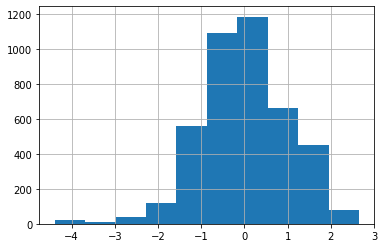

In [27]:
x['artist_familiarity'].hist()

In [28]:
train_size = int(0.8*len(x))
X_train = x.copy().iloc[:train_size]
X_train['loudness'] = np.log((x['loudness']**2))
y_train = y.copy().iloc[:train_size]
X_test = x.copy().iloc[train_size:]
y_test = y.copy().iloc[train_size:]
# y_train = np.log(y_train)
# y_test = np.log(y_test)

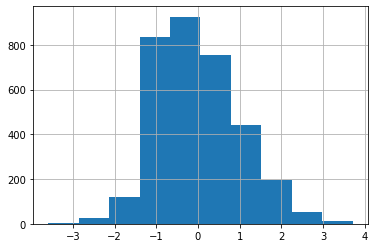

In [29]:
X_train['tempo'].hist()

In [30]:
# for label in time_sign_labels:
#     X_train[label] = X_train.copy()[label] * X_train.copy()['time_signature_confidence']

In [31]:
# for label in key_labels:
#     X_train[label] = X_train.copy()[label] * X_train.copy()['key_confidence']

In [32]:
cols = ['tempo','loudness','artist_hotttnesss','artist_familiarity']
regressor = RandomForestRegressor(n_estimators = 100)
accuracy = cross_val_score(regressor, X=X_train[cols], y=y_train, cv= 10, scoring='neg_mean_squared_error')
predicted = cross_val_predict(regressor, X=X_train[cols], y=y_train, cv= 10)

In [33]:
(((y_train - predicted)**2).mean())**(1/2)

0.14282550980975567

In [ ]:
'''
rmse of around 0.14 meaning our prediction is, with 95% confidence +- 0.14 the true value of song hotness, not bad 
'''

Text(0, 0.5, 'predicted y')

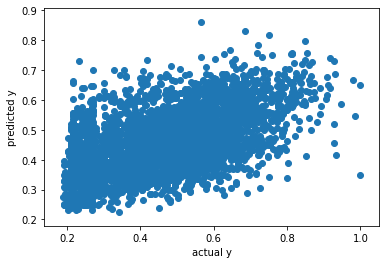

In [34]:
plt.scatter(y_train, predicted)
plt.xlabel('actual y')
plt.ylabel('predicted y')

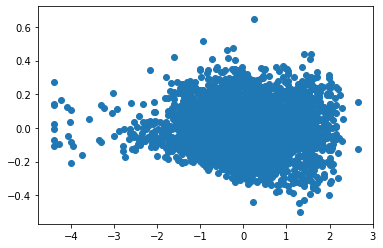

In [35]:
plt.scatter(X_train['artist_familiarity'], y_train -predicted)

In [36]:
'''
some skewness in residual plot that might need further investigation
'''

'\nsome skewness in residual plot that might need further investigation\n'

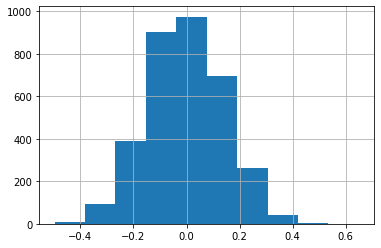

In [37]:
(y_train -predicted).hist()

In [38]:
regressor2 = RandomForestRegressor(n_estimators = 100)
regressor2.fit(X_train[cols], y_train)
accuracy2 = cross_val_score(regressor2, X=X_train[cols], y=y_train, cv= 10, scoring='r2')

In [39]:
accuracy2.mean()

0.28443823277509384

In [40]:
(accuracy.mean()*-1)**0.5

0.1426905422810095

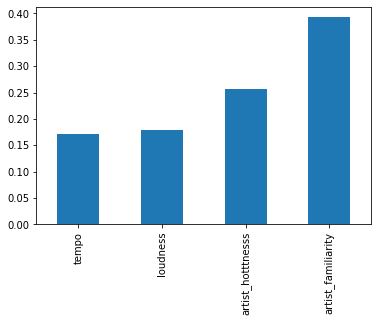

In [41]:
pd.Series(regressor2.feature_importances_, index=X_train[cols].columns).sort_values().plot.bar()

In [ ]:
'''
artist familiarity and hottness were the bigest predictor of song hottness among the 4 features used
'''

In [42]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train[cols])
linear_regression = LinearRegression()
lm_scores_r2 = cross_val_score(linear_regression, X_train_poly,y_train, cv= 10,scoring='r2' )
lm_scores_rmse = cross_val_score(linear_regression, X_train_poly,y_train, cv= 10,scoring='neg_mean_squared_error' )
lm_predict = cross_val_predict(linear_regression, X_train_poly,y_train, cv= 10)
print(lm_scores_r2.mean(), ' <---R^2')
print(lm_scores_rmse.mean(), ' <---rmse')

0.28490095013954625  <---R^2
-0.02030355994770283  <---rmse
